In [2]:
# Import Libraries required for the experiment
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier ,DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from six import StringIO
import collections
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [4]:
?AdaBoostClassifier

In [2]:
np.random.seed(132)
# Initiate Seaborn Package with a particular Style
sns.set(style="ticks", color_codes=True)

# Initiate Encoders which will be used for Categorical Variables
label_encoder = LabelEncoder()

# Prints all line without skipping
pd.set_option('display.max_rows', None)

# load the raw input dataset
bookings=pd.read_csv('D:\\Proj\\Coaching\\Coaching-ML\\ML Algorithms\\Boosting\\hotel-booking-demand\\hotel_bookings.csv')
bookings.head(10)
print(bookings.columns.values)

['hotel' 'is_canceled' 'lead_time' 'arrival_date_year'
 'arrival_date_month' 'arrival_date_week_number'
 'arrival_date_day_of_month' 'stays_in_weekend_nights'
 'stays_in_week_nights' 'adults' 'children' 'babies' 'meal' 'country'
 'market_segment' 'distribution_channel' 'is_repeated_guest'
 'previous_cancellations' 'previous_bookings_not_canceled'
 'reserved_room_type' 'assigned_room_type' 'booking_changes'
 'deposit_type' 'agent' 'company' 'days_in_waiting_list' 'customer_type'
 'adr' 'required_car_parking_spaces' 'total_of_special_requests'
 'reservation_status' 'reservation_status_date']


# Data Cleaning

In [3]:
#Assign Temporary Storage of the core dataset (For larger sets this step must be avoided)
temp=bookings.sample(10000)
temp=temp.drop(temp.columns[[5,6,13,23,24,31]],axis=1)
# Arrive at the logical columns that can be Categoric
# Conversion of String values to NaN if the real value is supposed to be Numeric
#temp.iloc[:,[0,1,3,13]]=temp.iloc[:,[0,1,3,13]].apply(lambda s: pd.to_numeric(s, errors='coerce'))
#print (temp.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all()))

# Column Null Value Check
temp['is_canceled'].isnull()

# Retrieve Columns that have Null Value 
null_columns=temp.columns[temp.isnull().any()]

# Retrieve Sample Rows for columns that have Null Value 
print(temp[temp.isnull().any(axis=1)][null_columns].head())

       children
41160       NaN


In [4]:
# Function to Point Out the Columns & Rows that have null values 
for i in range(1,len(null_columns)):
    print(null_columns[i])
    print('____________________________________________________________')
    print((pd.notnull(temp)[null_columns[i]]).value_counts())
    print(temp[(pd.isnull(temp)[null_columns[i]])][null_columns[i]])
    print('============================================================')

# Identify Categorical Variables for Better Automation of the entire script
temp1=temp.head()
temp1.iloc[:,[0,1,3,4,10,11,12,13,16,17,19,21]] = temp1.iloc[:,[0,1,3,4,10,11,12,13,16,17,19,21]].astype(str)
temp1.iloc[:,[0,1,3,4,10,11,12,13,16,17,19,21]].apply(LabelEncoder().fit_transform)


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\pandas\core\indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,hotel,is_canceled,arrival_date_year,arrival_date_month,meal,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,customer_type
115119,0,0,2,3,0,1,0,0,1,1,0,0
76228,0,1,0,0,1,0,0,0,0,0,1,1
31319,1,0,1,1,0,1,0,0,0,0,0,0
113563,0,0,2,3,0,1,0,0,2,2,0,0
63975,0,1,2,2,0,1,0,0,1,1,0,0


In [5]:

categoric_variables = temp1.columns[temp1.dtypes=='object']

# Categorical Imputation
for i in range(0,len(categoric_variables)):
    print(categoric_variables[i])
    print(temp[categoric_variables[i]].mode()[0])
    temp[categoric_variables[i]]=temp[categoric_variables[i]].replace(np.nan,temp[categoric_variables[i]].mode()[0])
    temp[categoric_variables[i]]=temp[categoric_variables[i]].replace(to_replace ="NaN", 
                 value =0)
    temp[categoric_variables[i]].fillna(0, inplace = True) 

hotel
City Hotel
is_canceled
0
arrival_date_year
2016
arrival_date_month
August
meal
BB
market_segment
Online TA
distribution_channel
TA/TO
is_repeated_guest
0
reserved_room_type
A
assigned_room_type
A
deposit_type
No Deposit
customer_type
Transient
reservation_status
Check-Out


## Numeric Imputation

In [6]:

# Numeric Imputation
from sklearn.impute import SimpleImputer
mean_imp = SimpleImputer(missing_values=np.nan, strategy="mean")
med_imp = SimpleImputer(missing_values=np.nan, strategy="median")

# Mean Imputation for Numeric Variables
numeric_variables = set(temp.columns) - set(categoric_variables)
i=1
for i in range(0,len(numeric_variables)):
    if(temp.columns[i] in numeric_variables):
       print(temp.columns[i])        
       temp.iloc[:,[i]] = mean_imp.fit_transform(temp.iloc[:,[i]])
       temp[temp.columns[i]]=temp[temp.columns[i]].replace(to_replace ="NaN", 
                 value =0)
       temp[temp.columns[i]].fillna(0, inplace = True) 

lead_time
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies


In [8]:
# Making Categoric for String Variables   
temp['hotel'] = temp['hotel'].astype(str)
temp['arrival_date_year'] = temp['arrival_date_year'].astype(str)
temp['arrival_date_month'] = temp['arrival_date_month'].astype(str)
temp['meal'] = temp['meal'].astype(str)
temp['market_segment'] = temp['market_segment'].astype(str)
temp['distribution_channel'] = temp['distribution_channel'].astype(str)
   
temp['is_repeated_guest'] = temp['is_repeated_guest'].astype(str)
temp['reserved_room_type'] = temp['reserved_room_type'].astype(str)
temp['assigned_room_type'] = temp['assigned_room_type'].astype(str)
temp['deposit_type'] = temp['deposit_type'].astype(str)
temp['customer_type'] = temp['customer_type'].astype(str)
temp['reservation_status'] = temp['reservation_status'].astype(str)

temp['is_canceled'] = temp['is_canceled'].astype(str)

# Data Transformation Checks

lead_time


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


stays_in_weekend_nights
stays_in_week_nights


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


adults
children
babies
previous_cancellations
previous_bookings_not_canceled


<ipython-input-9-8872cfb574de>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


booking_changes


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


days_in_waiting_list


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


adr


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


required_car_parking_spaces
total_of_special_requests


<Figure size 432x288 with 0 Axes>

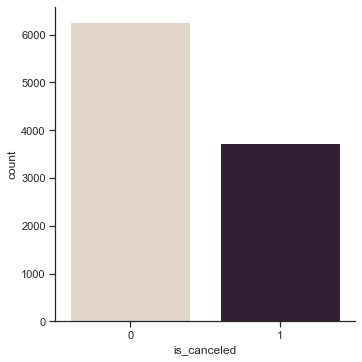

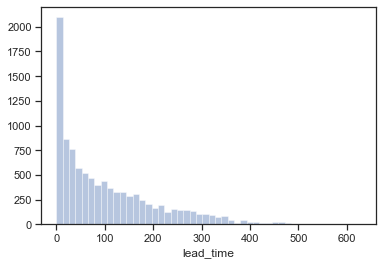

<Figure size 432x288 with 0 Axes>

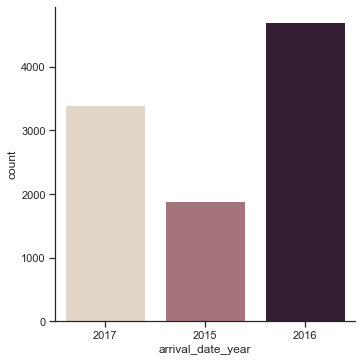

<Figure size 432x288 with 0 Axes>

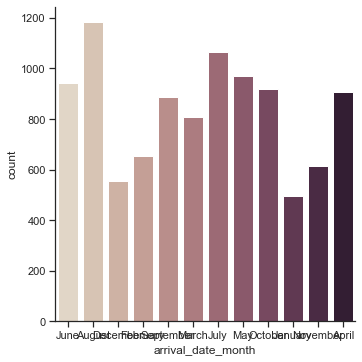

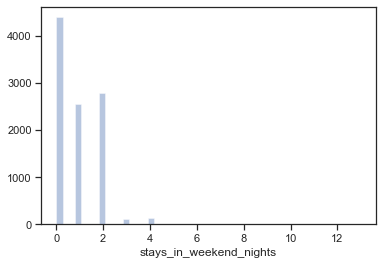

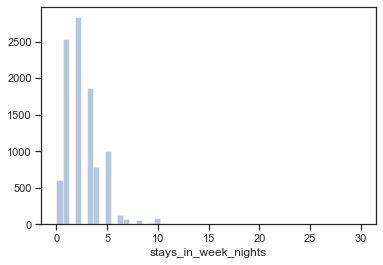

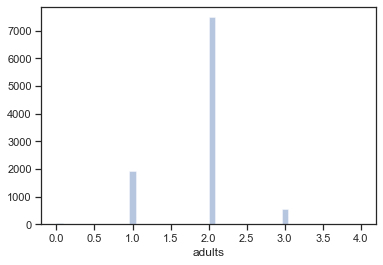

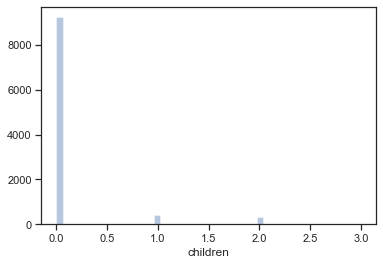

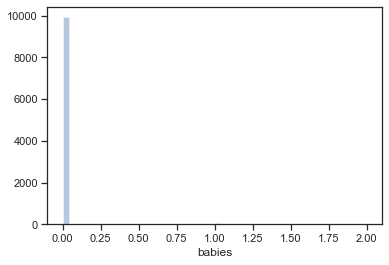

<Figure size 432x288 with 0 Axes>

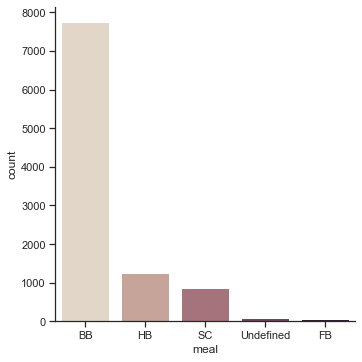

<Figure size 432x288 with 0 Axes>

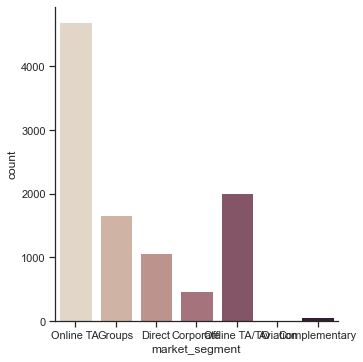

<Figure size 432x288 with 0 Axes>

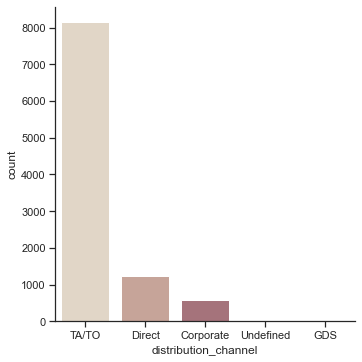

<Figure size 432x288 with 0 Axes>

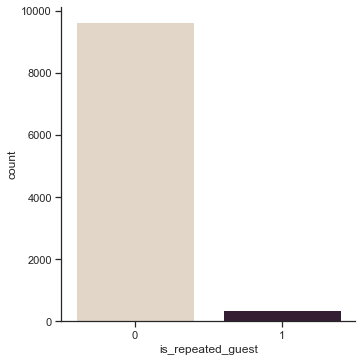

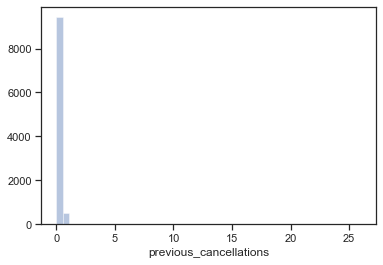

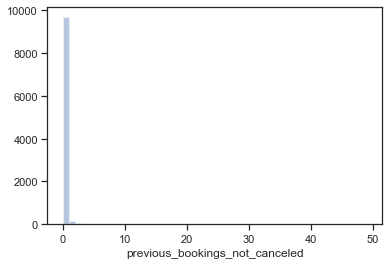

<Figure size 432x288 with 0 Axes>

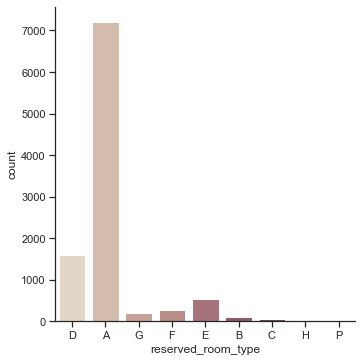

<Figure size 432x288 with 0 Axes>

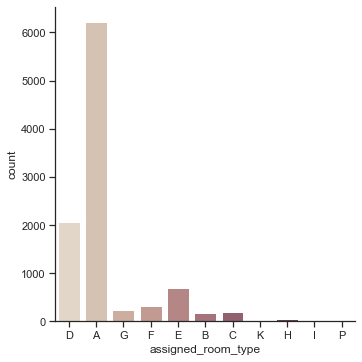

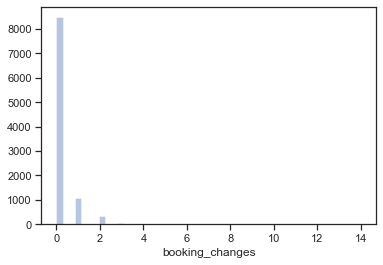

<Figure size 432x288 with 0 Axes>

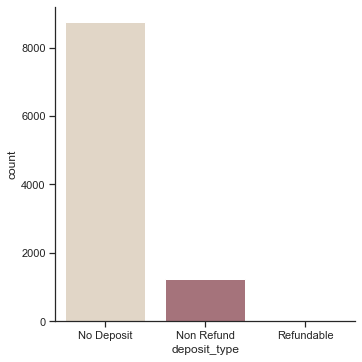

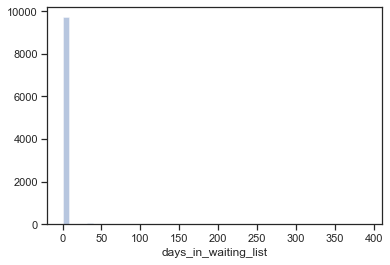

<Figure size 432x288 with 0 Axes>

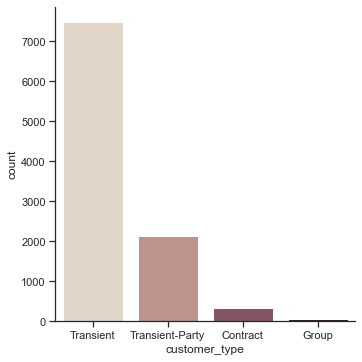

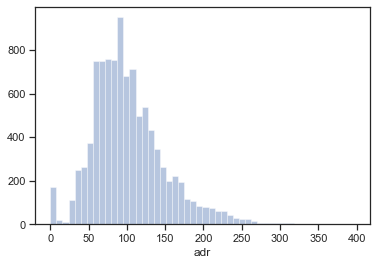

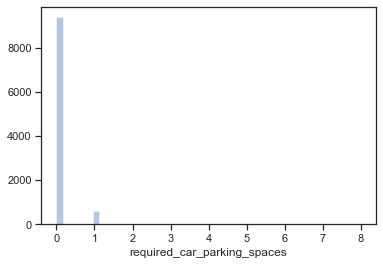

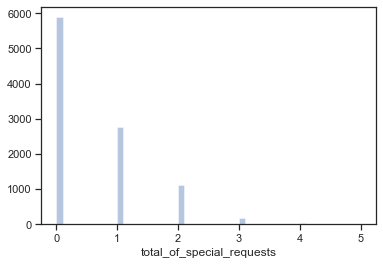

<Figure size 432x288 with 0 Axes>

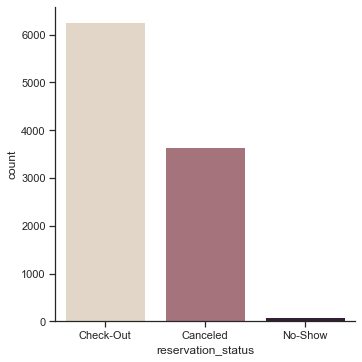

In [9]:

# Plotting All the Variables that are available in raw file
os.chdir('D:\\Proj\\Coaching\\Coaching-ML\\ML Algorithms\\Boosting\\')
if not os.path.exists('Plots'):
    os.makedirs('Plots')
os.chdir('D:\\Proj\\Coaching\\Coaching-ML\\ML Algorithms\\Boosting\\Plots\\')

for i in range(1,len(temp.columns)):
    if(temp.dtypes[i] in ('float64','int64')):
        print(temp.columns[i])
        plt.figure()
        sns_plot = sns.distplot(temp[temp.columns[i]], kde=False)
        sns_plot.figure.savefig(temp.columns[i]+'.png')
    else:
        plt.figure()
        sns_plot = sns.catplot(x=temp.columns[i], kind="count", palette="ch:.25", data=temp)
        sns_plot.savefig(temp.columns[i]+'.png')


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


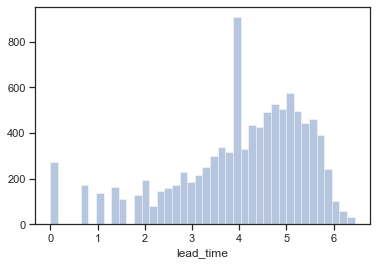

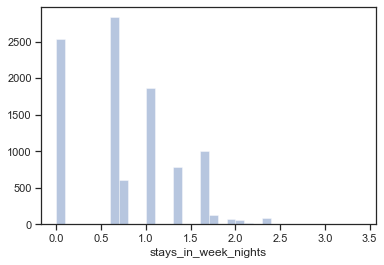

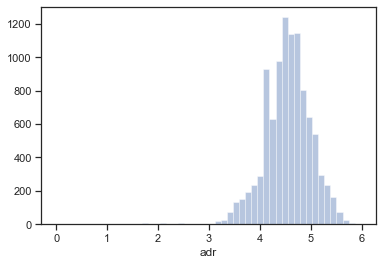

In [10]:

# Log transformation with mean Imputation for Non-Uniform Variables
log_mean_transform_var=['adr','lead_time','stays_in_week_nights']

# Plotting All the Transformed Variables 
os.chdir('D:\\Proj\\Coaching\\Coaching-ML\\ML Algorithms\\Boosting\\')
if not os.path.exists('Transformed Plots'):
    os.makedirs('Transformed Plots')
os.chdir('D:\\Proj\\Coaching\\Coaching-ML\\ML Algorithms\\Boosting\\Transformed Plots\\')

import time
for i in range(0,len(temp.columns)):
    if(temp.columns[i] in log_mean_transform_var):
        logtransform=np.log(temp[temp.columns[i]])
        logtransform = logtransform.replace([np.inf, -np.inf], np.nan)
        logtransform = mean_imp.fit_transform(pd.DataFrame(logtransform))
        temp[temp.columns[i]]=logtransform
        temp[temp.columns[i]].fillna(0, inplace = True) 

for i in range(1,len(temp.columns)):
    if(temp.columns[i] in log_mean_transform_var):
        plt.figure()
        sns_plot = sns.distplot(temp[temp.columns[i]], kde=False)
        sns_plot.figure.savefig(temp.columns[i]+'.png')


# Feature Engineering

## Correlation Technique

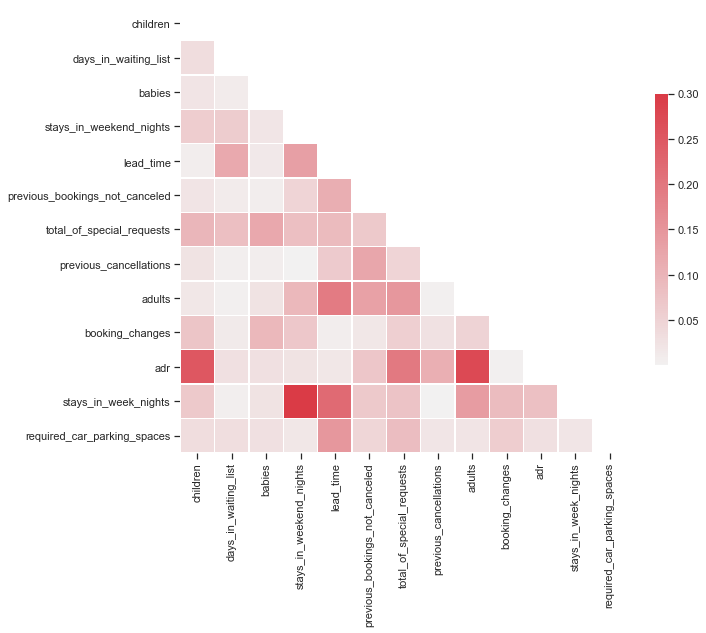

In [11]:

# Create correlation matrix
corr_matrix = temp[numeric_variables].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7 & less than -0.7
to_drop_pos = [column for column in upper.columns if any(upper[column] > 0.7)]
to_drop_neg = [column for column in upper.columns if any(upper[column] < -0.7)]

plt.figure(figsize=(10,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns_plot=sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns_plot.figure.savefig('correlation.png')
# Fill na values with Numeric value as 0
for i in range(1,len(temp.columns)):
    if(temp.dtypes[i] in ('float64','int64')):
        temp[temp.columns[i]].fillna(0, inplace = True) 


In [12]:
corr_matrix

,children,days_in_waiting_list,babies,stays_in_weekend_nights,lead_time,previous_bookings_not_canceled,total_of_special_requests,previous_cancellations,adults,booking_changes,adr,stays_in_week_nights,required_car_parking_spaces
children,1.000000,0.034344,0.022624,0.059892,0.007867,0.023362,0.097947,0.025581,0.017445,0.073339,0.252228,0.067036,0.033479
days_in_waiting_list,0.034344,1.000000,0.011582,0.061645,0.119250,0.009745,0.082479,0.005731,0.002743,0.014032,0.029193,0.004921,0.032081
babies,0.022624,0.011582,1.000000,0.020327,0.015683,0.009217,0.119577,0.008077,0.024484,0.095094,0.029106,0.024046,0.028570
stays_in_weekend_nights,0.059892,0.061645,0.020327,1.000000,0.134223,0.049215,0.083414,0.000963,0.095692,0.069297,0.025181,0.405142,0.017870
lead_time,0.007867,0.119250,0.015683,0.134223,1.000000,0.110440,0.090159,0.065092,0.194296,0.008978,0.018257,0.222054,0.149846
previous_bookings_not_canceled,0.023362,0.009745,0.009217,0.049215,0.110440,1.000000,0.066857,0.123874,0.131687,0.016738,0.070805,0.066366,0.045582
total_of_special_requests,0.097947,0.082479,0.119577,0.083414,0.090159,0.066857,1.000000,0.046917,0.148250,0.058082,0.194961,0.075236,0.084402
previous_cancellations,0.025581,0.005731,0.008077,0.000963,0.065092,0.123874,0.046917,1.000000,0.003220,0.027436,0.108974,0.000021,0.021006
adults,0.017445,0.002743,0.024484,0.095692,0.194296,0.131687,0.148250,0.003220,1.000000,0.049585,0.274373,0.139877,0.021292
booking_changes,0.073339,0.014032,0.095094,0.069297,0.008978,0.016738,0.058082,0.027436,0.049585,1.000000,0.003667,0.087072,0.060874


In [1]:

# Drop NaN Value from the temp variable
        
temp=temp.dropna(how='any') 


X = temp.drop(temp.columns[1],axis=1)
y = temp[temp.columns[1]]


# Identify Numeric Values separately
num_only=set(numeric_variables).difference(categoric_variables)


# Feature Importance for numeric variables 
# fit an Extra Trees model to the data
et_model_num = ExtraTreesClassifier()
et_model_num.fit(X[num_only], y)
# display the relative importance of each attribute
print(et_model_num.feature_importances_)
et_p_values_num = pd.Series(et_model_num.feature_importances_,index = X[num_only].columns)
et_p_values_num.sort_values(ascending = False , inplace = True)
et_p_values_num.index
plt.figure()
sns.set(rc={'figure.figsize':(11.7,8.27)})
pal = sns.color_palette("Greens_d")
sns.set_context("paper")
sns_plot = sns.barplot(et_p_values_num.index[et_p_values_num>0],et_p_values_num[et_p_values_num>0],alpha = 0.85)
plt.xticks(rotation=90)
plt.xlabel('Factors', fontsize = 11, weight = 'bold')
plt.ylabel('Feature Importance VALUE', fontsize = 11, weight = 'bold')
sns_plot.set_title("Variable Selection using Feature Importance", fontsize = 20, weight = 'bold')
sns_plot.figure.savefig('Feature_Importance'+'.png')
et_selected_num=et_p_values_num.index[et_p_values_num>0]
et_rejected_num=set(X[num_only].columns.values).difference(et_selected_num)

NameError: name 'temp' is not defined

[0.         0.         0.         0.         0.33283766 0.01711097
 0.26855383 0.12901733 0.         0.1557011  0.00960083 0.00215009
 0.0850282 ]


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


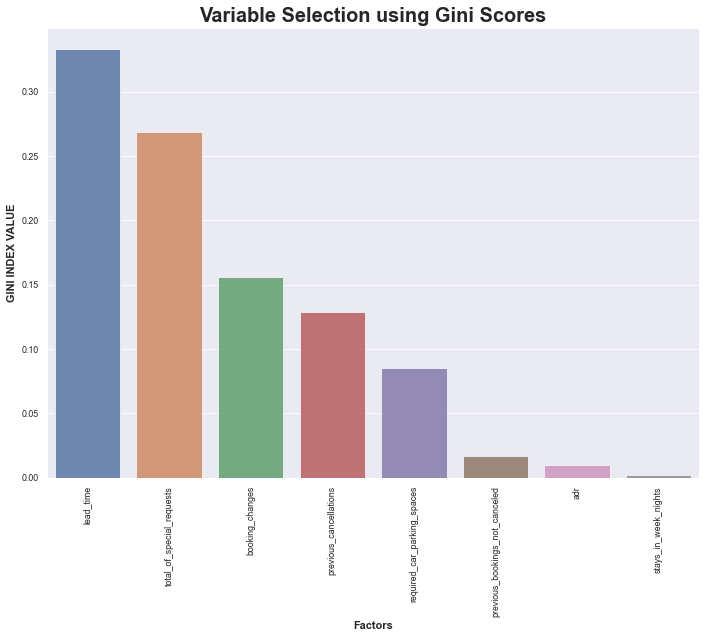

In [14]:
#GINI INDEX for numeric variables 

# Decision tree with gini 
dt_model_num = DecisionTreeClassifier( criterion='gini',
             random_state = 100, 
            max_depth = 5, min_samples_leaf = 20) 
  
# Performing training 
dt_model_num.fit(X[num_only], y)
print(dt_model_num.feature_importances_)

dt_p_values_num = pd.Series(dt_model_num.feature_importances_,index = X[num_only].columns)
dt_p_values_num.sort_values(ascending = False , inplace = True)
dt_p_values_num.index
plt.figure()
sns.set(rc={'figure.figsize':(11.7,8.27)})
pal = sns.color_palette("Greens_d")
sns.set_context("paper")
sns_plot = sns.barplot(dt_p_values_num.index[dt_p_values_num>0],dt_p_values_num[dt_p_values_num>0],alpha = 0.85)
plt.xticks(rotation=90)
plt.xlabel('Factors', fontsize = 11, weight = 'bold')
plt.ylabel('GINI INDEX VALUE', fontsize = 11, weight = 'bold')
sns_plot.set_title("Variable Selection using Gini Scores", fontsize = 20, weight = 'bold')
sns_plot.figure.savefig('GINI_INDEX'+'.png')

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00383181 0.88417911 0.00190858 0.00138724 0.00099276 0.00702828
 0.0091738  0.0022458  0.00240206 0.00694498 0.07589971 0.00400586]


C:\Users\techp\.conda\envs\cpuenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


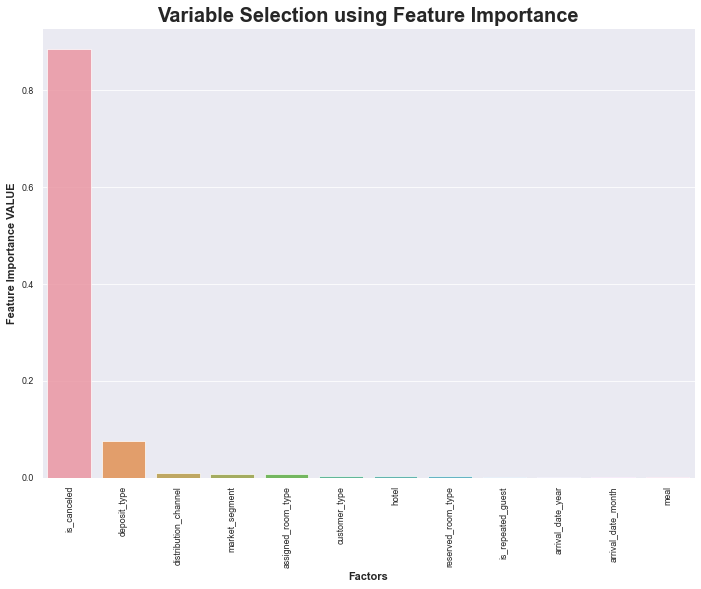

In [15]:

dt_selected_num=dt_p_values_num.index[dt_p_values_num>0]
dt_rejected_num=set(X[num_only].columns.values).difference(dt_selected_num)

temp.iloc[:,[0,1,3,4,10,11,12,13,16,17,19,21]] = temp.iloc[:,[0,1,3,4,10,11,12,13,16,17,19,21]].astype('category')
temp.iloc[:,[0,1,3,4,10,11,12,13,16,17,19,21]].apply(LabelEncoder().fit_transform)

# Selecting Categorical Variables alone for Variable Selection
t=temp.iloc[:,[0,1,3,4,10,11,12,13,16,17,19,21]]
# Dropping off NaN Values if Any
t=t.dropna(how='any')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in range(0,len(t.columns)):
    t.iloc[:,i] = le.fit_transform(t.iloc[:,i])
# Using GINI to decide Variables for Categoric Variables
from sklearn.tree import DecisionTreeRegressor 

dt_model_cat = DecisionTreeClassifier( criterion='gini',
             random_state = 100, 
            max_depth = 10, min_samples_leaf = 10)
dt_model_cat.fit(t, y) 
print(dt_model_cat.feature_importances_)

# dt_p_values_cat = pd.Series(dt_model_cat.feature_importances_,index = t.columns)
# dt_p_values_cat.sort_values(ascending = False , inplace = True)
# dt_p_values_cat.index
# plt.figure()
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# pal = sns.color_palette("Greens_d")
# sns.set_context("paper")
# sns_plot = sns.barplot(dt_p_values_cat.index[dt_p_values_cat>0],dt_p_values_cat[dt_p_values_cat>0],alpha = 0.85)
# plt.xticks(rotation=90)
# plt.xlabel('Factors', fontsize = 15, weight = 'bold')
# plt.ylabel('GINI INDEX VALUE', fontsize = 15, weight = 'bold')
# sns_plot.set_title("Variable Selection using Gini Scores (Categoric)", fontsize = 20, weight = 'bold')
# sns_plot.figure.savefig('GINI_INDEX_Categoric'+'.png')

# dt_selected_cat=dt_p_values_cat.index[dt_p_values_cat>0]
# dt_rejected_cat=dt_p_values_cat.index[dt_p_values_cat==0]


# Feature Importance for categoric variables 
# fit an Extra Trees model to the data
et_model_cat = ExtraTreesClassifier()
et_model_cat.fit(t, y) 
# display the relative importance of each attribute
print(et_model_cat.feature_importances_)
et_p_values_cat = pd.Series(et_model_cat.feature_importances_,index = t.columns)
et_p_values_cat.sort_values(ascending = False , inplace = True)
et_p_values_cat.index
plt.figure()
sns.set(rc={'figure.figsize':(11.7,8.27)})
pal = sns.color_palette("Greens_d")
sns.set_context("paper")
sns_plot = sns.barplot(et_p_values_cat.index[et_p_values_cat>0],et_p_values_cat[et_p_values_cat>0],alpha = 0.85)
plt.xticks(rotation=90)
plt.xlabel('Factors', fontsize = 11, weight = 'bold')
plt.ylabel('Feature Importance VALUE', fontsize = 11, weight = 'bold')
sns_plot.set_title("Variable Selection using Feature Importance", fontsize = 20, weight = 'bold')
sns_plot.figure.savefig('Feature_Importance'+'.png')
et_selected_cat=et_p_values_cat.index[et_p_values_cat>0.002]
et_rejected_cat=set(t.columns.values).difference(et_selected_cat)

In [16]:

rejected_variables=[]
rejected_variables.append(to_drop_pos)
rejected_variables.append(to_drop_neg)
rejected_variables.append(dt_rejected_num)
#rejected_variables.append(dt_rejected_cat)
rejected_variables.append(et_rejected_cat)
rejected_variables.append(et_rejected_num)

flattened_list = [y for x in rejected_variables for y in x]
rejected_variables_filter = list(dict.fromkeys(flattened_list))
print(rejected_variables_filter)


print(set(temp.columns).difference(rejected_variables_filter))

final_selection=set(temp.columns).difference(rejected_variables_filter)
final_selection.remove('is_canceled')

cat_vars=set(set(final_selection).difference(rejected_variables_filter)).difference(numeric_variables)
cat_vars1=cat_vars
final_selection=set(final_selection).difference(cat_vars1)
cat_vars.remove('reservation_status')
cat_vars.remove('assigned_room_type')
cat_vars.remove('hotel')
cat_vars.remove('distribution_channel')



data=pd.DataFrame()
data1=pd.DataFrame()
#cat_vars=['reservation_status','customer_type','market_segment','reserved_room_type','hotel','distribution_channel','arrival_date_year','assigned_room_type','meal','deposit_type','arrival_date_month',]
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(X[var], prefix=var)
    data1=pd.concat([data1,cat_list] ,axis=1)
    #data=data1


['children', 'days_in_waiting_list', 'babies', 'stays_in_weekend_nights', 'adults', 'arrival_date_year', 'meal', 'arrival_date_month']
{'reservation_status', 'lead_time', 'customer_type', 'total_of_special_requests', 'assigned_room_type', 'reserved_room_type', 'deposit_type', 'hotel', 'previous_bookings_not_canceled', 'market_segment', 'previous_cancellations', 'is_canceled', 'is_repeated_guest', 'required_car_parking_spaces', 'booking_changes', 'adr', 'stays_in_week_nights', 'distribution_channel'}


# Model Initiation

In [17]:
# Model Initiation

X_log=X[final_selection]
X_log=pd.concat([X_log,data1], axis=1)

RANDOM_SEED = 30
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.33, random_state=RANDOM_SEED)

# Boosting Model Initiation    

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
print('Parameters currently in use:\n')
print(clf.get_params())
clf.fit(X_train,y_train)

#Predict the response for train dataset
y_pred_train_random_rf = clf.predict(X_train)
y_pred_train_random_rf_a = clf.predict_proba(X_train)

#Predict the response for test dataset
y_pred_test_random_rf = clf.predict(X_test)
from sklearn.model_selection import cross_val_score

# K Fold Validation Metric
clf_cv_score = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
print("=== All AUC Scores ===")
print(clf_cv_score)
print('\n')
print("Mean AUC Score - Boosting: ", clf_cv_score.mean())


Parameters currently in use:

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 0}
=== All AUC Scores ===
[0.86866276 0.86300142 0.85532194 0.85293948 0.86253643 0.86177424
 0.86604082 0.85761345 0.85335414 0.86104682]


Mean AUC Score - Boosting:  0.860229149298928


In [18]:


# Train Data set metrics
pd.DataFrame(
    confusion_matrix(y_train, y_pred_train_random_rf),
    columns=['Predicted Not Cancelled', 'Predicted Cancelled'],
    index=['True Not Cancelled', 'True Cancelled']
)

,Predicted Not Cancelled,Predicted Cancelled
True Not Cancelled,3954,290
True Cancelled,901,1555


In [19]:
accuracy_score(y_train, y_pred_train_random_rf)

0.8222388059701492

In [20]:
classification_report(y_train, y_pred_train_random_rf)

'              precision    recall  f1-score   support\n\n           0       0.81      0.93      0.87      4244\n           1       0.84      0.63      0.72      2456\n\n    accuracy                           0.82      6700\n   macro avg       0.83      0.78      0.80      6700\nweighted avg       0.82      0.82      0.82      6700\n'

In [21]:
# Test Data set metrics
pd.DataFrame(
    confusion_matrix(y_test, y_pred_test_random_rf),
    columns=['Predicted Not Cancelled', 'Predicted Cancelled'],
    index=['True Not Cancelled', 'True Cancelled']
)

,Predicted Not Cancelled,Predicted Cancelled
True Not Cancelled,1888,137
True Cancelled,481,794


In [22]:

accuracy_score(y_test, y_pred_test_random_rf)

0.8127272727272727

In [23]:
classification_report(y_test, y_pred_test_random_rf)

'              precision    recall  f1-score   support\n\n           0       0.80      0.93      0.86      2025\n           1       0.85      0.62      0.72      1275\n\n    accuracy                           0.81      3300\n   macro avg       0.82      0.78      0.79      3300\nweighted avg       0.82      0.81      0.81      3300\n'

Text(185.6514, 0.5, 'predicted label')

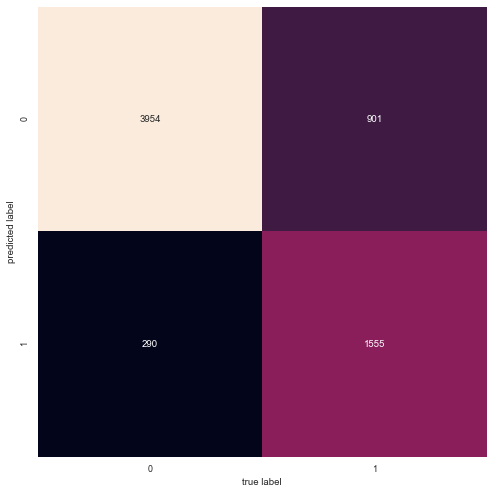

In [24]:
# Plotting of Confusion Matrix
mat = confusion_matrix(y_train, y_pred_train_random_rf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [25]:

clf1 = GradientBoostingClassifier( random_state=0)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf1.get_params())

criteria=['friedman_mse', 'mse', 'mae']
# Number of trees in Boosting
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5, 10,15,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5,7,10]
# Maximum number of samples required at each leaf node
max_leaf_nodes = [5,7,10]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,               
               #'min_weight_fraction_leaf':min_weight_fraction_leaf,
               'criterion' :criteria }
print(random_grid)

rf_random = RandomizedSearchCV(estimator = clf1, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)
best_random_rf = rf_random.best_estimator_

#Predict the response for train dataset
y_pred_train_random_rf = best_random_rf.predict(X_train)
y_pred_train_random_rf_a = best_random_rf.predict_proba(X_train)

#Predict the response for test dataset
y_pred_test_random_rf = best_random_rf.predict(X_test)
from sklearn.model_selection import cross_val_score


Parameters currently in use:

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'n_estimators': [50, 55, 61, 66, 72, 77, 83, 88, 94, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 6, 8, 9, 11, 13, 14, 16, 18, 20, None], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [5, 7, 10], 'criterion': ['friedman_mse', 'mse', 'mae']}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [26]:

# K Fold Validation Metric
rfc_cv_score = cross_val_score(best_random_rf, X_train, y_train, cv=10, scoring='roc_auc')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("Mean AUC Score - Boosting: ", rfc_cv_score.mean())

feature_list=X_train.columns.values
# Get numerical feature importances
importances = list(best_random_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20}     Importance: {}'.format(*pair)) for pair in feature_importances]

=== All AUC Scores ===
[0.89159572 0.8695352  0.87733452 0.86350476 0.87845145 0.87410838
 0.88267947 0.88026891 0.86223289 0.87792557]


Mean AUC Score - Boosting:  0.8757636870348693
Variable: deposit_type_Non Refund     Importance: 0.38
Variable: lead_time                Importance: 0.16
Variable: adr                      Importance: 0.1
Variable: total_of_special_requests     Importance: 0.08
Variable: market_segment_Online TA     Importance: 0.06
Variable: previous_cancellations     Importance: 0.05
Variable: stays_in_week_nights     Importance: 0.04
Variable: required_car_parking_spaces     Importance: 0.03
Variable: previous_bookings_not_canceled     Importance: 0.02
Variable: booking_changes          Importance: 0.02
Variable: customer_type_Transient-Party     Importance: 0.02
Variable: customer_type_Transient     Importance: 0.01
Variable: market_segment_Direct     Importance: 0.01
Variable: customer_type_Contract     Importance: 0.0
Variable: customer_type_Group      Importan

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:

# Train Data set metrics
pd.DataFrame(
    confusion_matrix(y_train, y_pred_train_random_rf),
    columns=['Predicted Not Cancelled', 'Predicted Cancelled'],
    index=['True Not Cancelled', 'True Cancelled']
)

,Predicted Not Cancelled,Predicted Cancelled
True Not Cancelled,4057,187
True Cancelled,650,1806


In [28]:
accuracy_score(y_train, y_pred_train_random_rf)

0.8750746268656716

In [29]:
classification_report(y_train, y_pred_train_random_rf)

'              precision    recall  f1-score   support\n\n           0       0.86      0.96      0.91      4244\n           1       0.91      0.74      0.81      2456\n\n    accuracy                           0.88      6700\n   macro avg       0.88      0.85      0.86      6700\nweighted avg       0.88      0.88      0.87      6700\n'

In [30]:
# Test Data set metrics
pd.DataFrame(
    confusion_matrix(y_test, y_pred_test_random_rf),
    columns=['Predicted Not Cancelled', 'Predicted Cancelled'],
    index=['True Not Cancelled', 'True Cancelled']
)


,Predicted Not Cancelled,Predicted Cancelled
True Not Cancelled,1881,144
True Cancelled,453,822


In [31]:
accuracy_score(y_test, y_pred_test_random_rf)

0.8190909090909091

In [32]:
classification_report(y_test, y_pred_test_random_rf)

'              precision    recall  f1-score   support\n\n           0       0.81      0.93      0.86      2025\n           1       0.85      0.64      0.73      1275\n\n    accuracy                           0.82      3300\n   macro avg       0.83      0.79      0.80      3300\nweighted avg       0.82      0.82      0.81      3300\n'

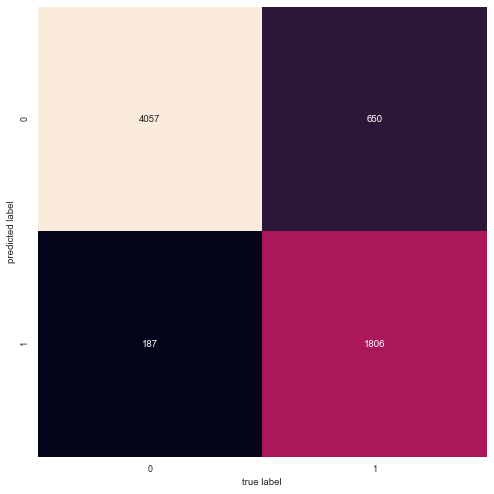

In [33]:
# Plotting of Confusion Matrix
mat = confusion_matrix(y_train, y_pred_train_random_rf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
import pydotplus

# Plotting One of the Group of Trees in Boosting
dot_data = StringIO()
indep_var=X_train.columns.values
features = [u'{}'.format(c) for c in indep_var]
sub_tree_42 = best_random_rf.estimators_[42, 0]
export_graphviz(sub_tree_42, out_file=dot_data, 
                feature_names=features,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [34]:

# Custom Colorization

colors = ('green','orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])


Image(graph.create_png())
graph.write_png("D:\\Proj\\Coaching\\Coaching-ML\\ML Algorithms\\Boosting\\rf_new_25.png")


True